# COMP2002 Assessment

This notebook will contain demonstrations of:
- Regression models trained to predict the Fire Weather Index (FWI) at a given time based on 12 numerical inputs from records of forest fires in 2 regions of Algeria.
- Optimisers designed to optimise routes between cities in the Travelling Salesman Problem.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
# Load forest file data using Pandas
forest_fire_region_1_data = pd.read_csv("./data/AlgerianFF_Region1.csv")
forest_fire_region_2_data = pd.read_csv("./data/AlgerianFF_Region2.csv")

In [3]:
# Copy data to avoid making permanent unrecoverable changes to the original
forest_fire_region_1_training_data = forest_fire_region_1_data.copy()
forest_fire_region_2_training_data = forest_fire_region_2_data.copy()

# Seperate FWI from the rest of the data, as this is the output we want to generate
forest_fire_region_1_training_targets = forest_fire_region_1_training_data.pop("FWI")
forest_fire_region_2_training_targets = forest_fire_region_2_training_data.pop("FWI")

In [4]:
# Create separate scalers for each dataset
ffr_1_scaler = MinMaxScaler()
ffr_2_scaler = MinMaxScaler()

# Fit each scaler on its own dataset
ffr_1_scaler.fit(forest_fire_region_1_training_data)
ffr_2_scaler.fit(forest_fire_region_2_training_data)

# Normalise each dataset using the now fitted scalers
scaled_ffr_1_training_data = ffr_1_scaler.transform(forest_fire_region_1_training_data)
scaled_ffr_2_training_data = ffr_1_scaler.transform(forest_fire_region_2_training_data)

In [5]:
# Initialise regressor objects
random_forest_regressor = RandomForestRegressor(n_estimators=100)
# Set max_iter to 1000 in order to reach convergence and solver to lbfgs for better performance on smaller datasets
neural_network_regressor = MLPRegressor(max_iter=1000, solver='lbfgs')
# Set kernel to linear for better performance
support_vector_regressor = SVR(kernel='linear')

In [6]:
# Train regressors on training data
random_forest_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)
neural_network_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)
support_vector_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [7]:
def test_on_point_in_dataset(regressor, point_index):
    prediction = regressor.predict(scaled_ffr_1_training_data[point_index].reshape(1, 12))
    prediction_string = f"Real: {forest_fire_region_1_training_targets[point_index]}\nPredicted by regressor: {prediction[0]}"
    return prediction_string

In [8]:
# Use trained random forest regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(random_forest_regressor, 0))

Real: 0.5
Predicted by regressor: 0.5329999999999999


In [9]:
# Use trained neural network regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(neural_network_regressor, 0))

Real: 0.5
Predicted by regressor: 0.49835136958957993


In [10]:
# Use trained support vector regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(support_vector_regressor, 0))

Real: 0.5
Predicted by regressor: 0.5744725713973874


In [11]:
def get_mae_from_testing_data(regressor, testing_data, testing_targets):
    predictions = regressor.predict(testing_data)
    return mean_absolute_error(testing_targets, predictions)

In [12]:
print(get_mae_from_testing_data(random_forest_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets))
print(get_mae_from_testing_data(neural_network_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets))
print(get_mae_from_testing_data(support_vector_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets))

1.1177540983606549
0.5143268880131227
1.204717604997872


In [13]:
def get_cross_validation_scores(regressor, testing_data, testing_targets):
    return cross_val_score(regressor, testing_data, testing_targets, cv=5)

In [14]:
def plot_cross_validation(cross_validation_data):
    # Set up labels
    regressor_labels = ["Random Forest Regressor", "Neural Network Regressor", "Support Vector Regressor"]
    # Set figsize to avoid labels overlapping
    plt.figure(figsize=(9.6, 7.2))
    # Plot data with labels
    plt.boxplot(cross_validation_data, labels=regressor_labels)
    
    
    plt.show()

In [15]:
random_forest_scores = get_cross_validation_scores(random_forest_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
neural_network_scores = get_cross_validation_scores(neural_network_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
support_vector_scores = get_cross_validation_scores(support_vector_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
print(random_forest_scores, neural_network_scores, support_vector_scores)

[0.97920984 0.96083882 0.94279279 0.85965632 0.98378723] [0.99590803 0.99770657 0.92288243 0.98719154 0.98498947] [0.88409408 0.97623018 0.90414872 0.95179938 0.96578783]


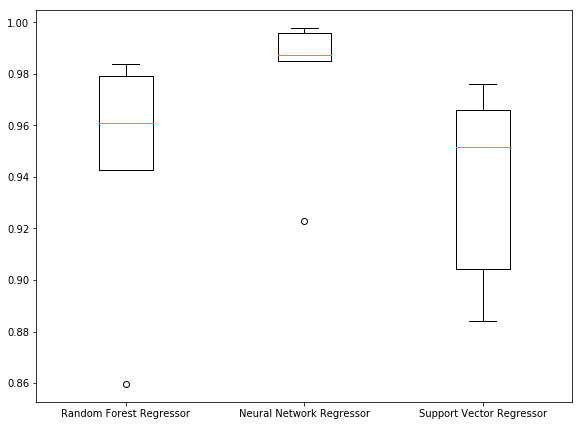

In [16]:
plot_cross_validation((random_forest_scores, neural_network_scores, support_vector_scores))